In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from FileReader import load_mnist
from __future__ import print_function

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_set = load_mnist('train')

In [4]:
train_img_set = torch.tensor(train_set['images']).to(device, torch.float)
train_label_set = torch.tensor(train_set['labels']).to(device, torch.long)

In [5]:
train_img_set = torch.unsqueeze(train_img_set, dim=1)

In [6]:
def degree_matrix(shape):
    
    deg_matrix = torch.zeros(*shape)
    deg_matrix[0,0] = -2
    deg_matrix[0,-1] = -2
    deg_matrix[-1,0] = -2
    deg_matrix[-1,-1] = -2
    deg_matrix += 5
    deg_matrix[1:-1,1:-1] += 3
    deg_matrix = deg_matrix.view(-1)
    return torch.diag(deg_matrix).to(device, torch.float)
deg_matrix = degree_matrix((28,28))

In [7]:
def adjacent_matrix(shape):
    
    height, width = shape
    adj_matrix = torch.zeros(height*width, height*width)
    for row in range(height):
        for col in range(width):
            if col+1 < width:
                adj_matrix[row*width+col, row*width+col+1] = 1
                adj_matrix[row*width+col+1, row*width+col] = 1
                if row+1 < height:
                    adj_matrix[row*width+col, (row+1)*width+col+1] = 1
                    adj_matrix[(row+1)*width+col+1, row*width+col] = 1
            if row+1 < height:
                adj_matrix[row*width+col, (row+1)*width+col] = 1
                adj_matrix[(row+1)*width+col, row*width+col] = 1
                if col-1 >= 0:
                    adj_matrix[row*width+col, (row+1)*width+col-1] = 1
                    adj_matrix[(row+1)*width+col-1, row*width+col] = 1
    return adj_matrix.to(device, torch.float)
adj_matrix = adjacent_matrix((28,28))

In [8]:
laplacian_matrix = deg_matrix - adj_matrix

In [9]:
eigenvalue,eigenvector = torch.symeig(laplacian_matrix, eigenvectors=True)

In [10]:
train_img_set = train_img_set.view(60000, -1)

In [11]:
class ConvGraph(nn.Module):
    
    def __init__(self, transform_matrix, vertex):
        super(ConvGraph, self).__init__()
        self.v_matrix = transform_matrix.detach()
        self.kernel_1 = nn.Parameter(torch.randn(vertex).to(device,torch.float))
        self.kernel_2 = nn.Parameter(torch.randn(vertex).to(device,torch.float))
        self.kernel_3 = nn.Parameter(torch.randn(vertex).to(device,torch.float))
        self.kernel_4 = nn.Parameter(torch.randn(vertex).to(device,torch.float))
    
    def forward(self, input):
        
        tensor = input.t()
        output_1 = F.relu(self.v_matrix.mm(torch.diag(self.kernel_1)).mm(self.v_matrix.t()).mm(tensor))
        output_2 = F.relu(self.v_matrix.mm(torch.diag(self.kernel_2)).mm(self.v_matrix.t()).mm(output_1))
        output_3 = F.relu(self.v_matrix.mm(torch.diag(self.kernel_3)).mm(self.v_matrix.t()).mm(output_2))
        output_4 = F.relu(self.v_matrix.mm(torch.diag(self.kernel_4)).mm(self.v_matrix.t()).mm(output_3))
        result = output_4.t()
        return result
        

In [12]:
class GCN(nn.Module):
    
    def __init__(self, transform_matrix, vertex):
        super(GCN, self).__init__()
        self.conv = ConvGraph(transform_matrix, vertex)
        self.fc_1 = nn.Linear(in_features=784, out_features=100)
        self.relu = nn.ReLU()
        self.fc_2 = nn.Linear(in_features=100, out_features=10)
    
    def forward(self, input):
        
        output_1 = self.conv(input)
        output_2 = self.fc_1(output_1)
        output_3 = self.relu(output_2)
        result = self.fc_2(output_3)
        return result

In [13]:
model = GCN(eigenvector, 784)

In [14]:
print(model)

GCN(
  (conv): ConvGraph()
  (fc_1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (fc_2): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
loss_stat = []

In [22]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [65]:
for step in range(100):
    
    y_pred = model(train_img_set)
    loss = loss_function(y_pred, train_label_set)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (step+1)%10 == 0:
        print('step: {} | loss: {}'.format(step+1, loss.data.item()))
    loss_stat.append(loss.data.item())

step: 10 | loss: 0.0112116094679
step: 20 | loss: 0.0110585978255
step: 30 | loss: 0.010909024626
step: 40 | loss: 0.0107615785673
step: 50 | loss: 0.0106172105297
step: 60 | loss: 0.0104758543894
step: 70 | loss: 0.0103369262069
step: 80 | loss: 0.0102006681263
step: 90 | loss: 0.0100671062246
step: 100 | loss: 0.00993581768125


In [17]:
test_set = load_mnist('t10k')
test_img_set = torch.tensor(test_set['images']).to(device, torch.float)
test_label_set = torch.tensor(test_set['labels']).to(device, torch.long)

In [66]:
top_k = 1
acc = 0
test_img_set = test_img_set.view(10000,-1)
pred = model(test_img_set)
ss, indices = torch.sort(pred, dim=1, descending=True)
results = indices[:,0:top_k]
for idx, label in enumerate(test_label_set):
    if label in results[idx]:
        acc += 1
print('accuracy:{}'.format(float(acc)/10000))

accuracy:0.9401


In [69]:
# torch.save(model.state_dict(), './mnist_GCN4.pkl')

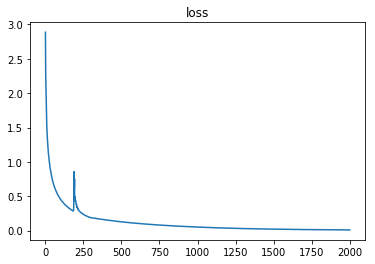

In [67]:
plt.figure()
plt.title('loss')
plt.plot(range(1, len(loss_stat)+1), loss_stat)
plt.show()